In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR

In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [4]:
def rand_tensor(min=0, max=1, size=(1)):
    out = (max - min) * torch.rand(size) + min
    return out

In [5]:
class Polynomial_func:
    def __init__(self, x, range=[-1,1], degree = 3, size=(1,1), sample_size=100, device="cuda"):
        self.x = x
        self.range = range
        self.degree = degree
        self.size = size
        self.sample_size = sample_size
        self.device = device

    def generate(self):
        hold = []
        for n in range(self.degree + 1):
            p = rand_tensor(
                min=self.range[0],
                max=self.range[1],
                size=(self.sample_size, self.size[0], self.size[1]),
            )
            hold.append(p)
        params = torch.stack(hold)
        params = torch.atleast_2d(params)
        params = torch.transpose(params, 0, 1)
        params = torch.transpose(params, 1, 2)
        params = params.to(self.device)

        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(self.device)
        )
        x = torch.transpose(x, 0, 1).to(self.device)
        y = torch.zeros_like(x)

        for d in range(self.degree+1):
            coeffs = params[:,0,d,0]
            y += coeffs*(x**d)
        out = torch.zeros(
                (params.shape[0], self.x.shape[0],
                self.size[0], self.size[1])
            ).to(self.device)            
        out[:,:,0,0] = torch.transpose(y,0,1)
        return (torch.sum(out,dim=3), out), params


In [6]:
def linear_function(params, x, device):
    x = x.to(device)
    if params.size(1) > 1:
        a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        return a*x + b
    else:
        return torch.zeros_like(params)

def quadratic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 2:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        return torch.zeros_like(params)

def cubic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 3:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        return torch.zeros_like(params)
    
def quartic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 4:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(4-n)
        return y
    else:
        return torch.zeros_like(params)
    
def quintic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 5:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(5-n)
        return y
    else:
        return torch.zeros_like(params)

In [7]:
class Multi_Func(nn.Module):
    def __init__(self, functions, x_data, input_channels, device):
        super().__init__()
        self.device = device
        self.functions = functions  # [[function, (...)], [# params, (...)]]
        self.x_data = x_data
        self.input_channels = input_channels
        self.params = sum(self.functions[1])

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 128), #28, 16
            nn.SELU(),
            nn.Linear(128, 64), #16, 8
            nn.SELU(),
            nn.Linear(64, self.params), #8
        )

    def forward(self, x, n=-1):
        target = x.squeeze(dim=2)
        x = torch.swapaxes(x, 1, 2).to(self.device)
        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))
        xfc = self.hidden_xfc(xfc)

        x = torch.reshape(x, (n, 2, 128))
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)

        loss_func = nn.MSELoss()
        start_index = 0
        losses = []
        outputs = []
        
        for f in range(len(self.functions[0])):
            output = self.functions[0][f](
                embedding[:, start_index:start_index+self.functions[1][f]], 
                self.x_data, 
                device=self.device
            ).to(device)
            outputs.append(output)
            loss = loss_func(output, target)
            losses.append(loss)
            start_index += self.functions[1][f]        
        best_index = torch.argmin(torch.tensor(losses))
        best_func = self.functions[0][best_index]
        best_loss, best_out = losses[best_index], outputs[best_index]

        return best_out, best_loss, best_func, outputs, losses



In [8]:
sample_size = 10000
batch_size = 50
data_range = [-1, 1]
num_funcs = 5

x_values = torch.linspace(data_range[0], data_range[1], 1000)

linear = Polynomial_func(x=x_values, range=data_range, degree=1, sample_size=sample_size, device=device)
lin_full, _ = linear.generate()[0]
lin_data = DataLoader(lin_full, batch_size=batch_size)

quad = Polynomial_func(x=x_values, range=data_range, degree=2, sample_size=sample_size, device=device)
quad_full, _ = quad.generate()[0]
quad_data = DataLoader(quad_full, batch_size=batch_size)

cube = Polynomial_func(x=x_values, range=data_range, degree=3, sample_size=sample_size, device=device)
cube_full, _ = cube.generate()[0]
cube_data = DataLoader(cube_full, batch_size=batch_size)

quart = Polynomial_func(x=x_values, range=data_range, degree=4, sample_size=sample_size, device=device)
quart_full, _ = quart.generate()[0]
quart_data = DataLoader(quart_full, batch_size=batch_size)

quint = Polynomial_func(x=x_values, range=data_range, degree=4, sample_size=sample_size, device=device)
quint_full, _ = quint.generate()[0]
quint_data = DataLoader(quint_full, batch_size=batch_size)

all_data = [cube_data, quad_data, lin_data, quart_data, quint_data]

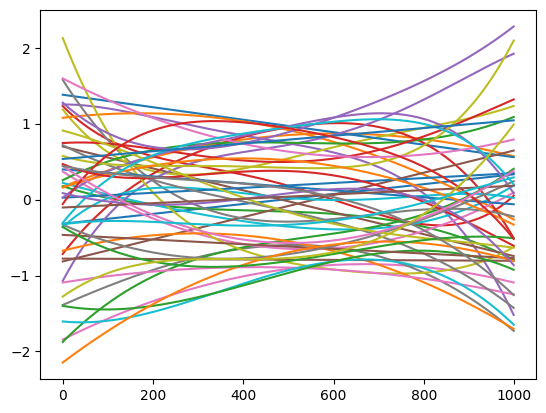

In [9]:
for i in range(10):
    r = np.random.randint(sample_size)
    plt.plot(lin_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(quad_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(cube_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(quart_full[r, :, 0].detach().cpu().numpy(), "-")
    plt.plot(quint_full[r, :, 0].detach().cpu().numpy(), "-")

In [10]:
def train(data, mod, los, opt, sch, epochs, dev):
    for epoch in range(epochs):
        start_time = time.time()
        train_loss = 0.0
        total_num = 0
        mod.train()

        for train_batch in data:
            train_batch = train_batch.to(dev)
            target_batch = train_batch.squeeze(2).to(dev)
            opt.zero_grad()
            best_out,_,_,_,_ = mod(train_batch)
            loss = los(best_out,target_batch)
            loss.backward()
            opt.step()
            train_loss += loss.item() * best_out.shape[0]
            total_num += best_out.shape[0]
        sch.step()
        train_loss /= total_num
        print(f"epoch : {epoch}/{epochs}, loss = {train_loss:.8f}")
        print(f"--- {time.time() - start_time} seconds ---")

In [11]:
functions = [[linear_function, quadratic_function, cubic_function, quartic_function, quintic_function], [2,3,4,5, 6]]
model = Multi_Func(functions=functions, x_data=x_values, input_channels=1, device=device).to(device)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [12]:
epochs = 50
for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    model.train()

    data = all_data[0]
    for n in range(num_funcs):
        if epoch % (n+1) == 0:
            data = all_data[n-1]

    for train_batch in data:
        train_batch = train_batch.to(device)
        target_batch = train_batch.squeeze(2).to(device)
        optimizer.zero_grad()
        best_out,_,_,_,_ = model(train_batch)
        loss = loss_func(best_out,target_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * best_out.shape[0]
        total_num += best_out.shape[0]
    scheduler.step()
    train_loss /= total_num
    print(f"epoch : {epoch}/{epochs}, loss = {train_loss:.8f}")
    print(f"--- {time.time() - start_time} seconds ---")

epoch : 0/50, loss = 0.03420107
--- 11.344430685043335 seconds ---
epoch : 1/50, loss = 0.00765915
--- 11.555221557617188 seconds ---
epoch : 2/50, loss = 0.00182713
--- 11.112560749053955 seconds ---
epoch : 3/50, loss = 0.00026873
--- 10.96688723564148 seconds ---
epoch : 4/50, loss = 0.00007947
--- 11.436179876327515 seconds ---
epoch : 5/50, loss = 0.00334390
--- 11.369820594787598 seconds ---
epoch : 6/50, loss = 0.00033643
--- 11.071879386901855 seconds ---
epoch : 7/50, loss = 0.00242730
--- 11.172828197479248 seconds ---
epoch : 8/50, loss = 0.00011414
--- 10.978119611740112 seconds ---
epoch : 9/50, loss = 0.00044774
--- 11.464924573898315 seconds ---
epoch : 10/50, loss = 0.00220969
--- 11.076690196990967 seconds ---
epoch : 11/50, loss = 0.00207875
--- 11.090989112854004 seconds ---
epoch : 12/50, loss = 0.00002229
--- 11.211393356323242 seconds ---
epoch : 13/50, loss = 0.00205135
--- 11.119889736175537 seconds ---
epoch : 14/50, loss = 0.00006994
--- 11.199814558029175 sec

In [ ]:
train(quart_data, model, loss_func, optimizer, scheduler, 50, device)

In [13]:
t_sample_size = 100

t_x_values = torch.linspace(-1, 1, 1000)
t_linear = Polynomial_func(x=x_values, range=[-1,1], degree=1, sample_size=t_sample_size, device=device)
t_quad = Polynomial_func(x=x_values, range=[-1,1], degree=2, sample_size=t_sample_size, device=device)
t_cube = Polynomial_func(x=x_values, range=[-1,1], degree=3, sample_size=t_sample_size, device=device)
t_quart = Polynomial_func(x=x_values, range=data_range, degree=4, sample_size=sample_size, device=device)
t_quint = Polynomial_func(x=x_values, range=data_range, degree=4, sample_size=sample_size, device=device)


t_lin_full, _ = t_linear.generate()[0]
t_quad_full, _ = t_quad.generate()[0]
t_cube_full, _ = t_cube.generate()[0]
t_quart_full, _ = t_quart.generate()[0]
t_quint_full, _ = t_quint.generate()[0]

t_data = torch.vstack([t_lin_full, t_quad_full, t_cube_full, t_quart_full, t_quint_full])

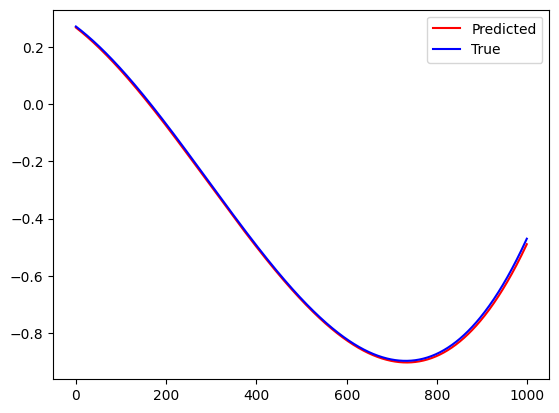

In [68]:
model.eval
best_out, best_loss, best_func, outputs, losses = model(t_data)
rand = np.random.randint(0, t_sample_size*num_funcs)
plt.plot(best_out[rand].detach().cpu().numpy(), "r", label='Predicted')
plt.plot(t_data[rand].detach().cpu().numpy(), "b", label='True')
plt.legend();